In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.0'

# Visualizing what convnets learn

This notebook contains the code sample found in Chapter 5, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

It is often said that deep learning models are "black boxes", learning representations that are difficult to extract and present in a 
human-readable form. While this is partially true for certain types of deep learning models, it is definitely not true for convnets. The 
representations learned by convnets are highly amenable to visualization, in large part because they are _representations of visual 
concepts_. Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. We won't 
survey all of them, but we will cover three of the most accessible and useful ones:

* Visualizing intermediate convnet outputs ("intermediate activations"). This is useful to understand how successive convnet layers 
transform their input, and to get a first idea of the meaning of individual convnet filters.
* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive 
to.
* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging 
to a given class, and thus allows to localize objects in images.

For the first method -- activation visualization -- we will use the small convnet that we trained from scratch on the cat vs. dog 
classification problem two sections ago. For the next two methods, we will use the VGG16 model that we introduced in the previous section.

## Visualizing intermediate activations

Visualizing intermediate activations consists in displaying the feature maps that are output by various convolution and pooling layers in a 
network, given a certain input (the output of a layer is often called its "activation", the output of the activation function). This gives 
a view into how an input is decomposed unto the different filters learned by the network. These feature maps we want to visualize have 3 
dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these 
feature maps is by independently plotting the contents of every channel, as a 2D image.
Let's start by loading the model that we saved in section 5.2:

In [2]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         


This will be the input image we will use -- a picture of a cat, not part of images that the network was trained on:

In [4]:
img_path = '/root/examples/cats_and_dogs_small/test/cats/cat.1700.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


Let's display our picture:

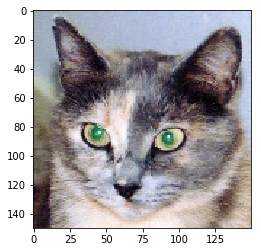

In [6]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps we want to look at, we will create a Keras model that takes batches of images as input, and outputs 
the activations of all convolution and pooling layers. To do this, we will use the Keras class `Model`. A `Model` is instantiated using two 
arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors). The resulting class is a Keras 
model, just like the `Sequential` models that you are familiar with, mapping the specified inputs to the specified outputs. What sets the 
`Model` class apart is that it allows for models with multiple outputs, unlike `Sequential`. For more information about the `Model` class, see 
Chapter 7, Section 1.

In [8]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. This is the first time you encounter 
a multi-output model in this book: until now the models you have seen only had exactly one input and one output. In the general case, a 
model could have any number of inputs and outputs. This one has one input and 8 outputs, one output per layer activation.

In [9]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

For instance, this is the activation of the first convolution layer for our cat image input:

In [11]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It's a 148x148 feature map with 32 channels. Let's try visualizing the 3rd channel:

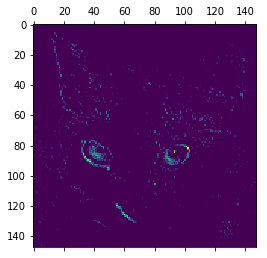

In [12]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

This channel appears to encode a diagonal edge detector. Let's try the 30th channel -- but note that your own channels may vary, since the 
specific filters learned by convolution layers are not deterministic.

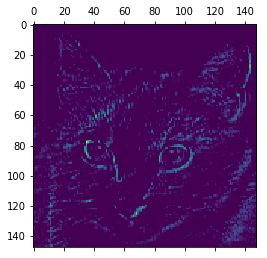

In [13]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

This one looks like a "bright green dot" detector, useful to encode cat eyes. At this point, let's go and plot a complete visualization of 
all the activations in the network. We'll extract and plot every channel in each of our 8 activation maps, and we will stack the results in 
one big image tensor, with channels stacked side by side.

/root/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


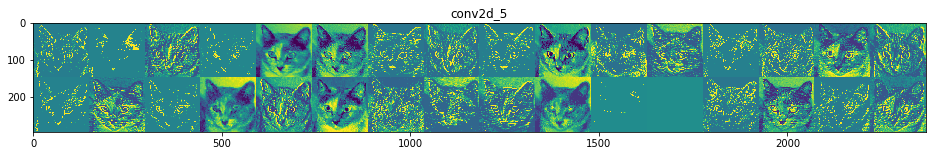

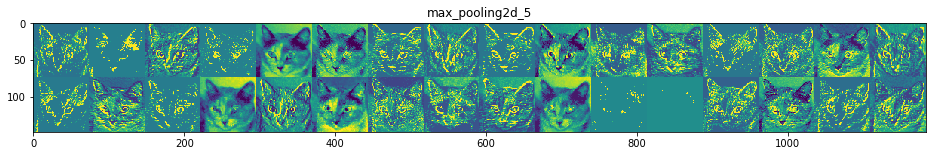

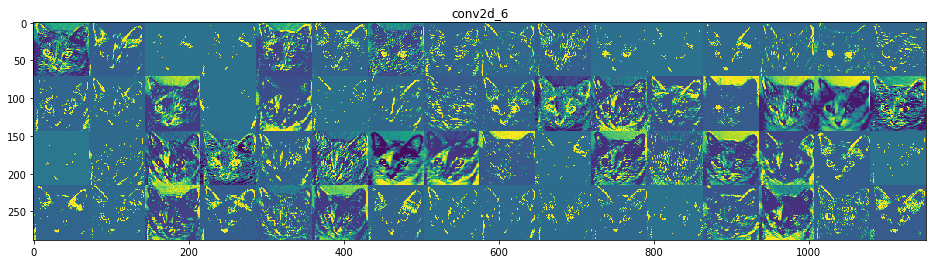

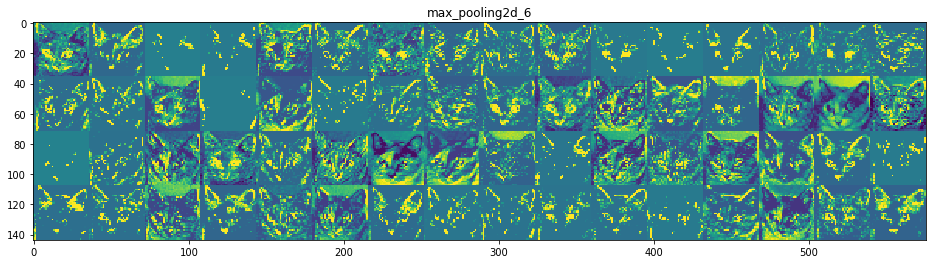

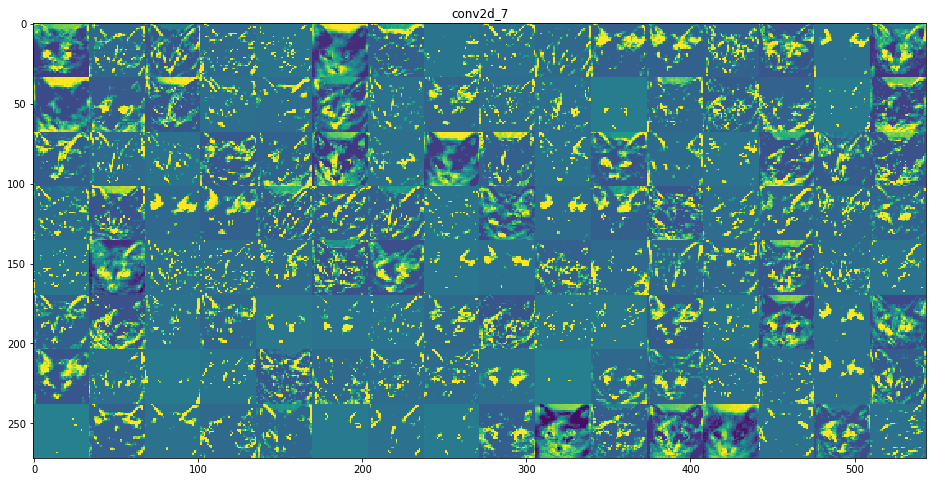

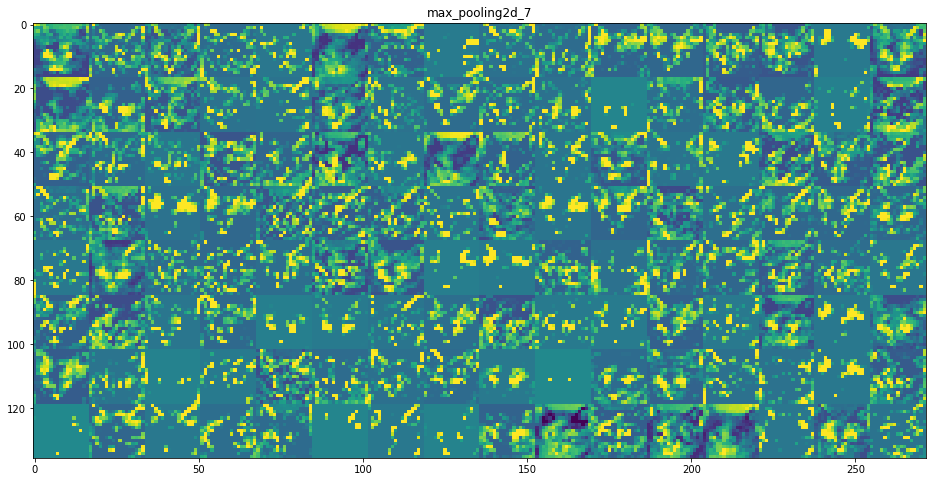

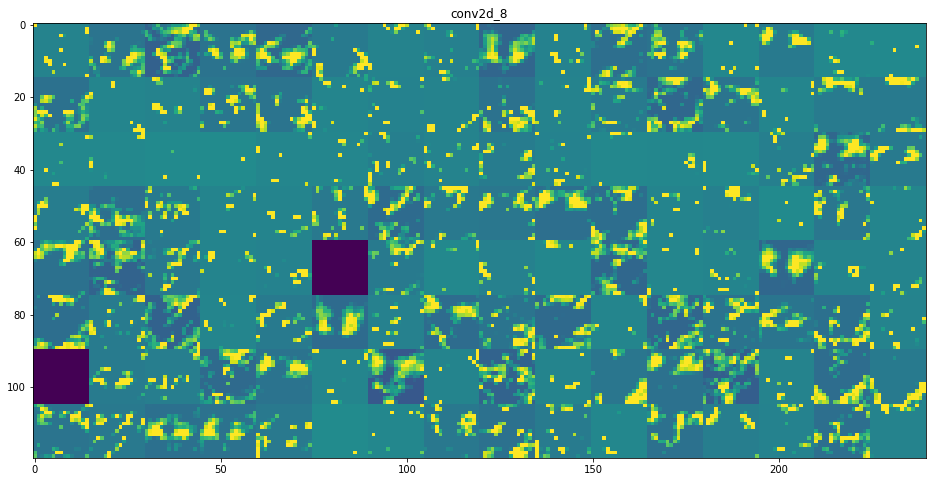

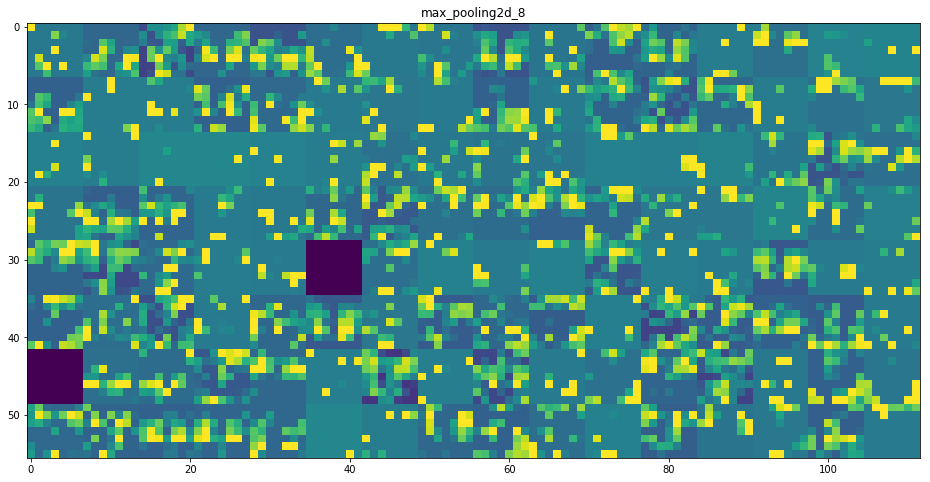

In [14]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

A few remarkable things to note here:

* The first layer acts as a collection of various edge detectors. At that stage, the activations are still retaining almost all of the 
information present in the initial picture.
* As we go higher-up, the activations become increasingly abstract and less visually interpretable. They start encoding higher-level 
concepts such as "cat ear" or "cat eye". Higher-up presentations carry increasingly less information about the visual contents of the 
image, and increasingly more information related to the class of the image.
* The sparsity of the activations is increasing with the depth of the layer: in the first layer, all filters are activated by the input 
image, but in the following layers more and more filters are blank. This means that the pattern encoded by the filter isn't found in the 
input image.


We have just evidenced a very important universal characteristic of the representations learned by deep neural networks: the features 
extracted by a layer get increasingly abstract with the depth of the layer. The activations of layers higher-up carry less and less 
information about the specific input being seen, and more and more information about the target (in our case, the class of the image: cat 
or dog). A deep neural network effectively acts as an __information distillation pipeline__, with raw data going in (in our case, RBG 
pictures), and getting repeatedly transformed so that irrelevant information gets filtered out (e.g. the specific visual appearance of the 
image) while useful information get magnified and refined (e.g. the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which 
abstract objects were present in it (e.g. bicycle, tree) but could not remember the specific appearance of these objects. In fact, if you 
tried to draw a generic bicycle from mind right now, chances are you could not get it even remotely right, even though you have seen 
thousands of bicycles in your lifetime. Try it right now: this effect is absolutely real. You brain has learned to completely abstract its 
visual input, to transform it into high-level visual concepts while completely filtering out irrelevant visual details, making it 
tremendously difficult to remember how things around us actually look.

## Visualizing convnet filters


Another easy thing to do to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond 
to. This can be done with __gradient ascent in input space__: applying __gradient descent__ to the value of the input image of a convnet so 
as to maximize the response of a specific filter, starting from a blank input image. The resulting input image would be one that the chosen 
filter is maximally responsive to.

The process is simple: we will build a loss function that maximizes the value of a given filter in a given convolution layer, then we 
will use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. For instance, here's 
a loss for the activation of filter 0 in the layer "block3_conv1" of the VGG16 network, pre-trained on ImageNet:

In [15]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

To implement gradient descent, we will need the gradient of this loss with respect to the model's input. To do this, we will use the 
`gradients` function packaged with the `backend` module of Keras:

In [16]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

A non-obvious trick to use for the gradient descent process to go smoothly is to normalize the gradient tensor, by dividing it by its L2 
norm (the square root of the average of the square of the values in the tensor). This ensures that the magnitude of the updates done to the 
input image is always within a same range.

In [17]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Now we need a way to compute the value of the loss tensor and the gradient tensor, given an input image. We can define a Keras backend 
function to do this: `iterate` is a function that takes a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy 
tensors: the loss value and the gradient value.

In [18]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

At this point we can define a Python loop to do stochastic gradient descent:

In [19]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

The resulting image tensor will be a floating point tensor of shape `(1, 150, 150, 3)`, with values that may not be integer within `[0, 
255]`. Hence we would need to post-process this tensor to turn it into a displayable image. We do it with the following straightforward 
utility function:

In [20]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Now we have all the pieces, let's put them together into a Python function that takes as input a layer name and a filter index, and that 
returns a valid image tensor representing the pattern that maximizes the activation the specified filter:

In [21]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

Let's try this:

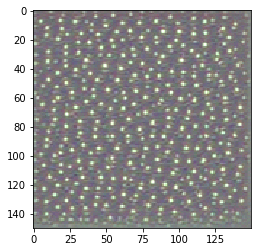

In [22]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

It seems that filter 0 in layer `block3_conv1` is responsive to a polka dot pattern.

Now the fun part: we can start visualising every single filter in every layer. For simplicity, we will only look at the first 64 filters in 
each layer, and will only look at the first layer of each convolution block (block1_conv1, block2_conv1, block3_conv1, block4_conv1, 
block5_conv1). We will arrange the outputs on a 8x8 grid of 64x64 filter patterns, with some black margins between each filter pattern.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


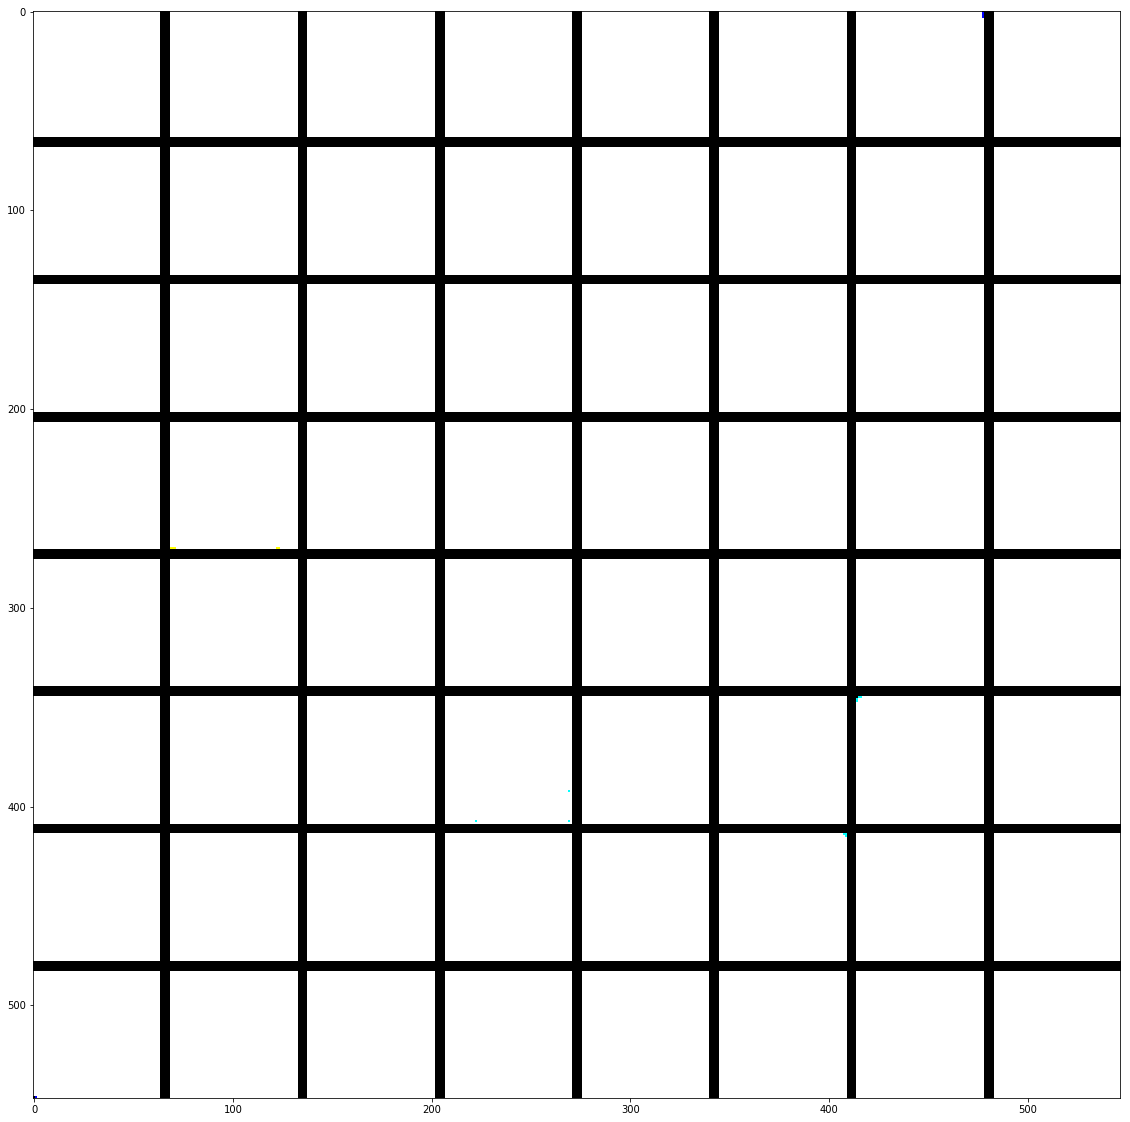

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


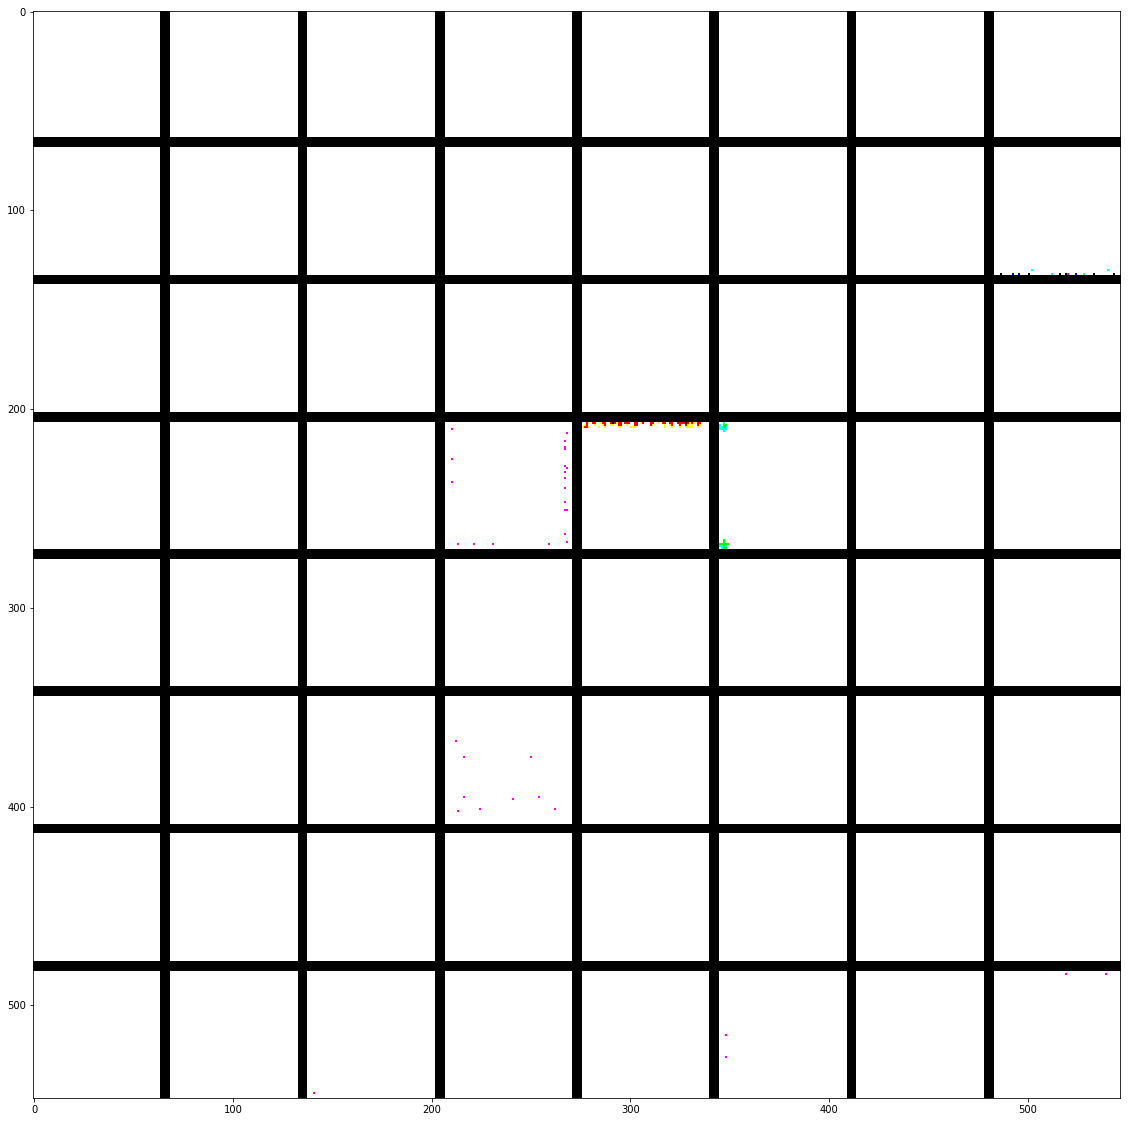

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


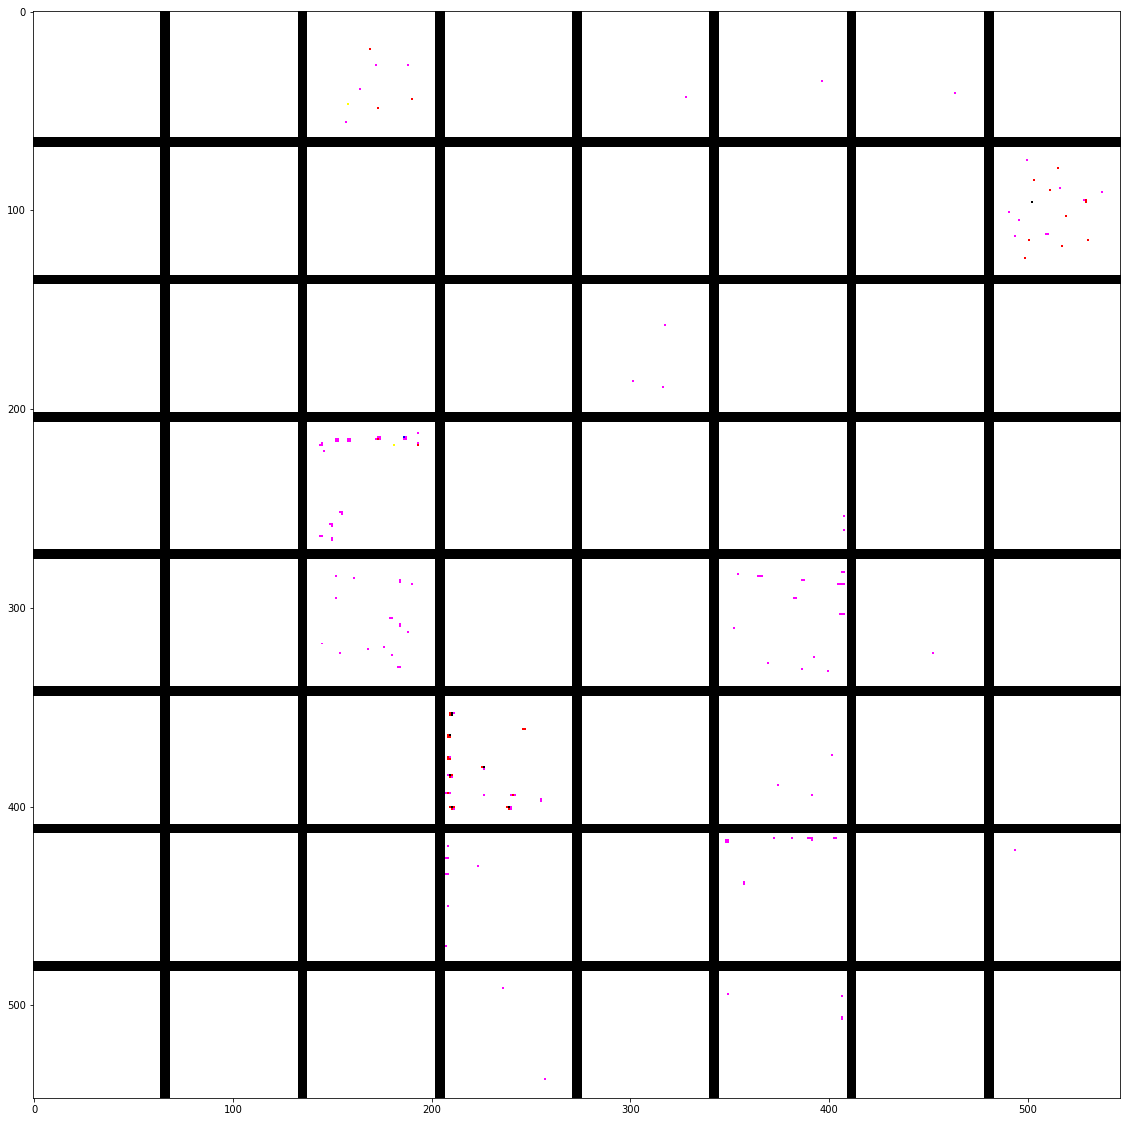

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


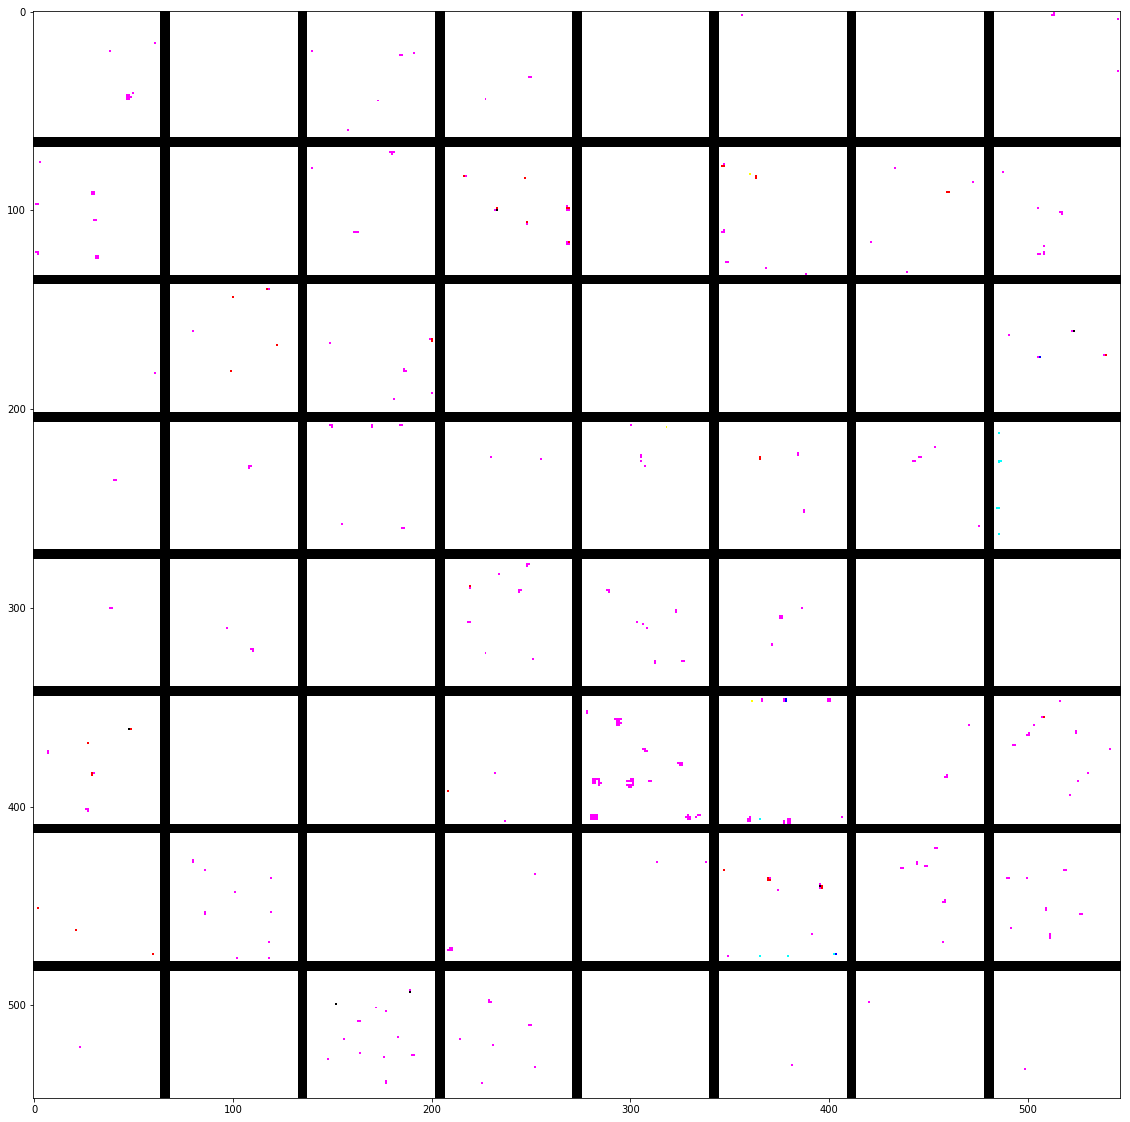

In [24]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

These filter visualizations tell us a lot about how convnet layers see the world: each layer in a convnet simply learns a collection of 
filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes 
signals onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as we go higher-up 
in the model:

* The filters from the first layer in the model (`block1_conv1`) encode simple directional edges and colors (or colored edges in some 
cases).
* The filters from `block2_conv1` encode simple textures made from combinations of edges and colors.
* The filters in higher-up layers start resembling textures found in natural images: feathers, eyes, leaves, etc.

## Visualizing heatmaps of class activation

We will introduce one more visualization technique, one that is useful for understanding which parts of a given image led a convnet to its 
final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification 
mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class 
activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for 
every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a 
image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", 
indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the 
image are.

The specific implementation we will use is the one described in [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). It is very simple: it consists in taking the output feature map of a 
convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the 
channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates 
different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input 
image activates the class".

We will demonstrate this technique using the pre-trained VGG16 network again:

In [25]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 116s 0us/step


Let's consider the following image of two African elephants, possible a mother and its cub, strolling in the savanna (under a Creative 
Commons license):

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224x244, preprocessed according 
to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize 
it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

In [29]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = '/root/examples/deep-learning-with-python-notebooks/creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [30]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]



The top-3 classes predicted for this image are:

* African elephant (with 92.5% probability)
* Tusker (with 7% probability)
* Indian elephant (with 0.4% probability)

Thus our network has recognized our image as containing an undetermined quantity of African elephants. The entry in the prediction vector 
that was maximally activated is the one corresponding to the "African elephant" class, at index 386:

In [31]:
np.argmax(preds[0])

386

To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

In [32]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

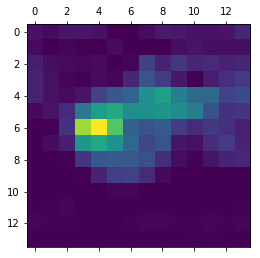

In [33]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:

In [36]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('/root/examples/deep-learning-with-python-notebooks/elephant_cam.jpg', superimposed_img)

True

![elephant cam](https://s3.amazonaws.com/book.keras.io/img/ch5/elephant_cam.jpg)

This visualisation technique answers two important questions:

* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it is interesting to note that the ears of the elephant cub are strongly activated: this is probably how the network can 
tell the difference between African and Indian elephants.
